<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-python-by-francois-chollet/7-deep-dive-into-keras/02_keras_training_and_evaluation_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Keras model fundamentals

There are three APIs for building models in Keras:

* The Sequential model, the most approachable API—it’s basically a Python list. As such, it’s limited to simple stacks of layers.
* The Functional API, which focuses on graph-like model architectures. It represents
a nice mid-point between usability and flexibility, and as such, it’s the
most commonly used model-building API.
* Model subclassing, a low-level option where you write everything yourself from
scratch. This is ideal if you want full control over every little thing. However, you
won’t get access to many built-in Keras features, and you will be more at risk of
making mistakes.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-python-by-francois-chollet/7-deep-dive-into-keras/images/1.png?raw=1' width='600'/>

##Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.datasets import mnist

import random
import string
import re

import numpy as np

##Using built-in training and evaluation loops

The principle of progressive disclosure of complexity—access to a spectrum of workflows
that go from dead easy to arbitrarily flexible, one step at a time—also applies to
model training. Keras provides you with different workflows for training models. 

They
can be as simple as calling `fit()` on your data, or as advanced as writing a new training
algorithm from scratch.



In [2]:
def get_mnist_model():
  inputs = keras.Input(shape=(28 * 28, ))
  features = layers.Dense(512, activation="relu")(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation="softmax")(features)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

Load your data, reserving
some for validation.

In [4]:
(images, labels), (test_images, test_labels) = mnist.load_data()

images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [5]:
model = get_mnist_model()

# Compile the model by specifying its optimizer, the loss function to minimize, and the metrics to monitor
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model, optionally providing validation data to monitor performance on unseen data
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))

Epoch 1/3
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2915 - accuracy: 0.9135 - val_loss: 0.1507 - val_accuracy: 0.9565
Epoch 2/3
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1678 - accuracy: 0.9536 - val_loss: 0.1202 - val_accuracy: 0.9682
Epoch 3/3
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1389 - accuracy: 0.9627 - val_loss: 0.1135 - val_accuracy: 0.9708


In [7]:
# compute the loss and metrics on new data
test_metrics = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.1087 - accuracy: 0.9725


In [8]:
# compute classification probabilities on new data
predictions = model.predict(test_images)

There are a couple of ways you can customize this simple workflow:

* Provide your own custom metrics.
* Pass `callbacks` to the `fit()` method to schedule actions to be taken at specific points during training.


##Writing your own metrics

##Functional API

The Sequential model is easy to use, but its applicability is extremely limited: it can
only express models with a single input and a single output, applying one layer after
the other in a sequential fashion.

Let’s start with something simple.

In [ ]:
inputs = keras.Input(shape=(3, ), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)

model = keras.Model(inputs=inputs, outputs=outputs)

This inputs object holds information about the shape and dtype of the data that the
model will process:

In [ ]:
inputs.shape

TensorShape([None, 3])

In [ ]:
inputs.dtype

tf.float32

We call such an object a symbolic tensor. It doesn’t contain any actual data, but it
encodes the specifications of the actual tensors of data that the model will see when
you use it. It stands for future tensors of data.

All Keras layers can be called both on real tensors of data and on these symbolic tensors.

In [ ]:
features.shape

TensorShape([None, 64])

In [ ]:
features.dtype

tf.float32

Here’s the summary of our model:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


###Creating multi-input and multi-output

As you will see, most deep learning models don’t look like lists—they look like
graphs. They may, for instance, have multiple inputs or multiple outputs. It’s for this
kind of model that the Functional API really shines.

Let’s say you’re building a system to rank customer support tickets by priority and
route them to the appropriate department. Your model has three inputs:

* The title of the ticket (text input)
* The text body of the ticket (text input)
* Any tags added by the user (categorical input, assumed here to be one-hot
encoded)

Your model also has two outputs:
* The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
* The department that should handle the ticket (a softmax over the set of departments)

In [ ]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# Define model inputs
title = keras.Input(shape=(vocabulary_size, ), name="title")
text_body = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags = keras.Input(shape=(num_tags, ), name="tags")

# Combine input features into a single tensor, features, by concatenating them.
features = layers.Concatenate()([title, text_body, tags])
# Apply an intermediate layer to recombine input features into richer representations
features = layers.Dense(64, activation="relu")(features)

# Define model outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# Create the model by specifying its inputs and outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

The Functional API is a simple, LEGO-like, yet very flexible way to define arbitrary
graphs of layers like these.

###Training multi-input and multi-output

You can train your model in much the same way as you would train a Sequential
model, by calling `fit()` with lists of input and output data.

In [ ]:
num_samples = 1280

# dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)

40/40 [==============================] - 1s 13ms/step - loss: 30.8845 - priority_loss: 0.3362 - department_loss: 30.5483 - priority_mean_absolute_error: 0.5040 - department_accuracy: 0.2461


In [ ]:
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])

40/40 [==============================] - 0s 5ms/step - loss: 3.7930 - priority_loss: 0.3380 - department_loss: 3.4550 - priority_mean_absolute_error: 0.5056 - department_accuracy: 0.5859


[3.7930126190185547,
 0.3380233645439148,
 3.454989194869995,
 0.5056027173995972,
 0.5859375]

In [ ]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

In [ ]:
priority_preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
department_preds

array([[0.84385276, 0.02321451, 0.05782586, 0.07510676],
       [0.28783002, 0.49439   , 0.02621931, 0.19156067],
       [0.5313341 , 0.07290258, 0.04487287, 0.35089043],
       ...,
       [0.5803476 , 0.05759914, 0.01671531, 0.34533787],
       [0.72417957, 0.06754033, 0.02001124, 0.18826894],
       [0.67184055, 0.10336391, 0.05131271, 0.17348276]], dtype=float32)

If you don’t want to rely on input order (for instance, because you have many inputs
or outputs), you can also leverage the names you gave to the Input objects and the
output layers, and pass data via dictionaries.

In [ ]:
model.compile(optimizer="rmsprop", 
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"}, 
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, 
          {"priority": priority_data, "department": department_data}, epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, 
          {"priority": priority_data, "department": department_data})

40/40 [==============================] - 0s 6ms/step - loss: 30.5513 - priority_loss: 0.3380 - department_loss: 30.2133 - priority_mean_absolute_error: 0.5056 - department_accuracy: 0.0680


[30.551349639892578,
 0.3380233645439148,
 30.213321685791016,
 0.5056027173995972,
 0.06796874850988388]

In [ ]:
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [ ]:
priority_preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
department_preds

array([[2.02314183e-08, 3.25519312e-03, 2.39944508e-15, 9.96744752e-01],
       [4.72251793e-10, 1.79023147e-02, 1.63657962e-16, 9.82097685e-01],
       [2.29997341e-10, 1.54593226e-03, 7.28297258e-17, 9.98454094e-01],
       ...,
       [8.63428828e-10, 1.57810503e-03, 4.60607914e-17, 9.98421907e-01],
       [1.97313921e-09, 9.15059994e-04, 1.01871964e-16, 9.99084949e-01],
       [4.83980078e-10, 1.57466773e-02, 1.49814082e-16, 9.84253347e-01]],
      dtype=float32)

###The power of Functional API

A Functional model is an explicit graph data structure. This makes it possible to
inspect how layers are connected and reuse previous graph nodes (which are layer
outputs) as part of new models. It also nicely fits the “mental model” that most researchers
use when thinking about a deep neural network: a graph of layers. This enables
two important use cases: model visualization and feature extraction.

Let’s visualize the connectivity of the model we just defined (the topology of the
model).

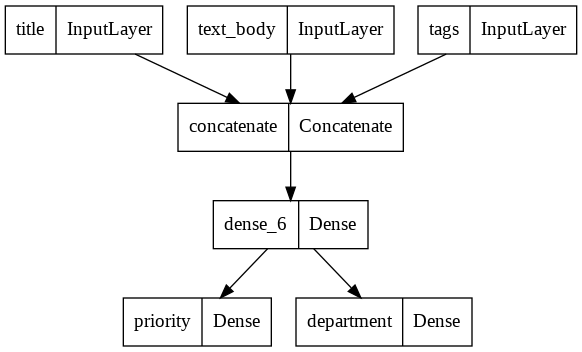

In [ ]:
keras.utils.plot_model(model, "ticket_classifier.png")

You can add to this plot the input and output shapes of each layer in the model, which
can be helpful during debugging.

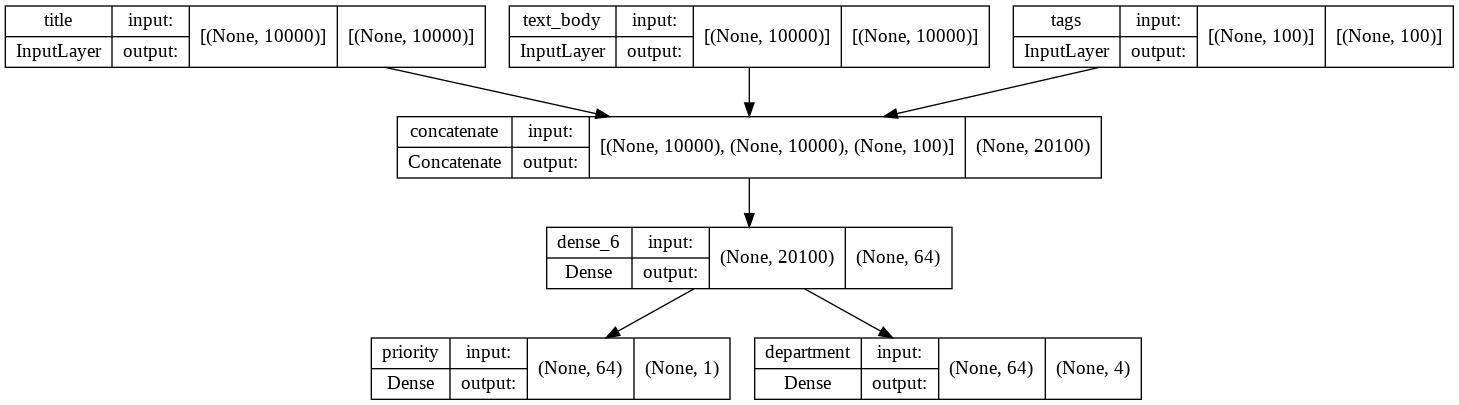

In [ ]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

The “None” in the tensor shapes represents the batch size: this model allows batches
of any size.

Access to layer connectivity also means that you can inspect and reuse individual
nodes (layer calls) in the graph. 

The `model.layers` model property provides the list
of layers that make up the model, and for each layer you can query `layer.input` and `layer.output`.

In [ ]:
model.layers

In [ ]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [ ]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

This enables you to do feature extraction, creating models that reuse intermediate features
from another model.

Let’s say you want to add another output to the previous model—you want to estimate
how long a given issue ticket will take to resolve, a kind of difficulty rating. 

You could do this via a classification layer over three categories: “quick,” “medium,” and “difficult.” 

You don’t need to recreate and retrain a model from scratch. You can start
from the intermediate features of your previous model, since you have access to them,
like this.

In [ ]:
# layers[4] is our intermediate Dense layer
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model =  keras.Model(inputs=[title, text_body, tags], outputs=[priority, department, difficulty])

Let’s plot our new model.

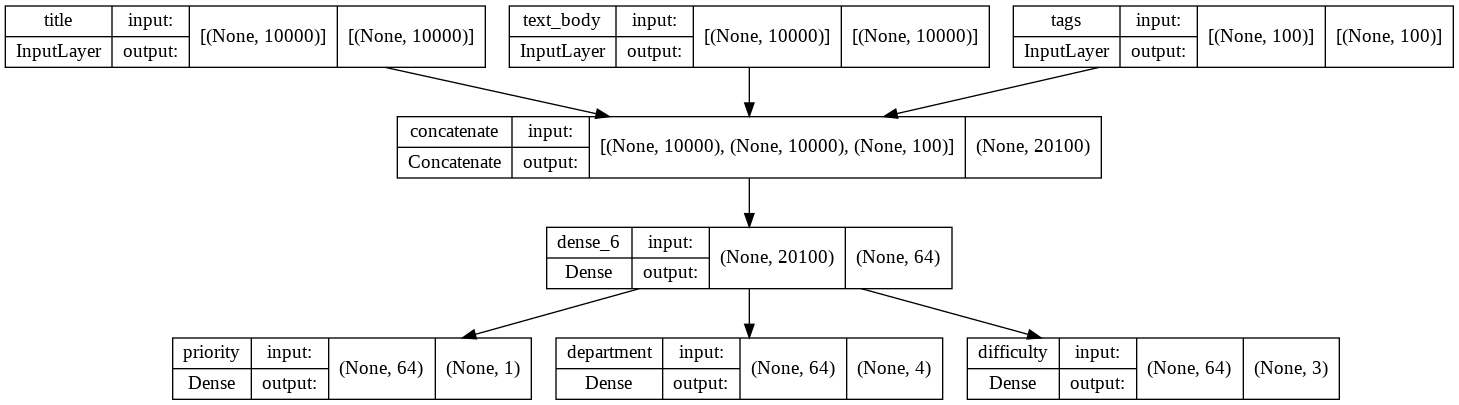

In [ ]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

##Subclassing the Model class

The last model-building pattern you should know about is the most advanced one:
Model subclassing.

Subclassing is pretty similar Model:
* In the `__init__()` method, define the layers the model will use.
* In the `call()` method, define the forward pass of the model, reusing the layers previously created.
* Instantiate your subclass, and call it on data to create its weights.

Let’s take a look at a simple example: we will reimplement the customer support ticket
management model using a Model subclass.


In [ ]:
class CustomerTicketModel(keras.Model):

  def __init__(self, num_departments) -> None:
    # Don’t forget to call the super() constructor!
    super().__init__()
    # Define sublayers in the constructor.
    self.concat_layer = layers.Concatenate()
    self.mixing_layer = layers.Dense(64, activation="relu")
    self.priority_scorer = layers.Dense(1, activation="sigmoid")
    self.department_classifier = layers.Dense(num_departments, activation="softmax")

  def call(self, inputs):
    title = inputs["title"]
    text_body = inputs["text_body"]
    tags = inputs["tags"]

    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)
    priority = self.priority_scorer(features)
    department = self.department_classifier(features)

    return priority, department

Once you’ve defined the model, you can instantiate it. 

Note that it will only create its
weights the first time you call it on some data, much like Layer subclasses:

In [ ]:
model = CustomerTicketModel(num_departments=4)

In [ ]:
num_samples = 1280
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [ ]:
priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [ ]:
priority

<tf.Tensor: shape=(1280, 1), dtype=float32, numpy=
array([[0.5092661 ],
       [0.37069905],
       [0.60188127],
       ...,
       [0.7110101 ],
       [0.50514495],
       [0.27605012]], dtype=float32)>

In [ ]:
department

<tf.Tensor: shape=(1280, 4), dtype=float32, numpy=
array([[0.20488036, 0.1842343 , 0.05597334, 0.554912  ],
       [0.83344275, 0.01262661, 0.02163043, 0.13230021],
       [0.5117641 , 0.03121655, 0.08218714, 0.37483215],
       ...,
       [0.39985433, 0.05226773, 0.23640406, 0.31147385],
       [0.4012751 , 0.07318418, 0.07348944, 0.45205128],
       [0.14873205, 0.04966399, 0.09099649, 0.7106075 ]], dtype=float32)>

It’s simple: a “layer” is a building block you use to create models, and a “model”
is the top-level object that you will actually train, export for inference, etc.

In short, a
Model has `fit()`, `evaluate()`, and `predict()` methods. Layers don’t. Other than that,
the two classes are virtually identical.

You can compile and train a Model subclass just like a Sequential or Functional
model:

In [ ]:
# The structure of what you pass as the loss and metrics arguments must match exactly what gets returned by call()—here, a list of two elements.
model.compile(optimizer="rmsprop", 
              loss=["mean_squared_error", "categorical_crossentropy"], 
              metrics=[["mean_absolute_error"], ["accuracy"]])

# The structure of the input data must match exactly what is expected by the call() method—here, a dict with keys title, text_body, and tags.
# The structure of the target data must match exactly what is returned by the call() method—here, a list of two elements.
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, [priority_data, department_data], epochs=1)

40/40 [==============================] - 1s 10ms/step - loss: 28.6239 - output_1_loss: 0.3245 - output_2_loss: 28.2993 - output_1_mean_absolute_error: 0.4921 - output_2_accuracy: 0.2305


In [ ]:
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, [priority_data, department_data])

40/40 [==============================] - 0s 5ms/step - loss: 32.3730 - output_1_loss: 0.3298 - output_2_loss: 32.0432 - output_1_mean_absolute_error: 0.4980 - output_2_accuracy: 0.2602


[32.37300109863281,
 0.3298144042491913,
 32.043190002441406,
 0.49799150228500366,
 0.2601562440395355]

In [ ]:
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [ ]:
priority_preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
department_preds

array([[8.1883627e-07, 9.9999917e-01, 5.7633003e-14, 2.7894659e-10],
       [1.8162224e-06, 9.9999821e-01, 2.4095477e-14, 2.7298391e-10],
       [7.6240133e-07, 9.9999928e-01, 2.9036354e-14, 7.4898470e-09],
       ...,
       [1.8075964e-06, 9.9999821e-01, 9.5929727e-14, 7.8634554e-10],
       [9.2639164e-07, 9.9999905e-01, 5.3533295e-14, 1.4397943e-09],
       [2.4637627e-06, 9.9999750e-01, 8.5802046e-14, 8.5591695e-10]],
      dtype=float32)

The Model subclassing workflow is the most flexible way to build a model. It enables
you to build models that cannot be expressed as directed acyclic graphs of layers—
imagine, for instance, a model where the `call()` method uses layers inside a for loop,
or even calls them recursively.

##Mixing and matching different components

All models in the Keras API
can smoothly interoperate with each other, whether they’re Sequential models, Functional
models, or subclassed models written from scratch. They’re all part of the same
spectrum of workflows.

For instance, you can use a subclassed layer or model in a Functional model.

In [ ]:
class Classifier(keras.Model):

  def __init__(self, num_classes=2) -> None:
      super().__init__()

      if num_classes == 2:
        num_units = 1
        activation = "soigmoid"
      else:
        num_units = num_classes
        activation = "softmax"
      self.dense = layers.Dense(num_units, activation=activation)

  def call(self, inputs):
      return self.dense(inputs)

In [ ]:
inputs = keras.Input(shape=(64, ))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

Inversely, you can use a Functional model as part of a subclassed layer or model.

In [ ]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
class MyModel(keras.Model):

  def __init__(self, num_classes=2) -> None:
      super().__init__()

      self.dense = layers.Dense(64, activation="relu")
      self.classifier = binary_classifier

  def call(self, inputs):
      features = self.dense(inputs)
      return self.classifier(features)

In [ ]:
model = MyModel()

##Conclusion

In general, the Functional API provides you with a pretty good trade-off between
ease of use and flexibility. It also gives you direct access to layer connectivity, which is
very powerful for use cases such as model plotting or feature extraction. 

If you can use
the Functional API—that is, if your model can be expressed as a directed acyclic graph
of layers—I recommend using it over model subclassing.

In general, using Functional models
that include subclassed layers provides the best of both worlds: high development flexibility
while retaining the advantages of the Functional API.

